In [22]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.optimizers import SGD

In [23]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "../data/ripeness_classification/apple/train"  # os.path.abspath("media")

datagen_kwargs = dict(rescale=1.0 / 255, validation_split=0.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", target_size=IMAGE_SHAPE
)

Found 27 images belonging to 3 classes.
Found 117 images belonging to 3 classes.


In [24]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)  # Update the number of classes here

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])


steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
4/4 [==============================] - 9s 1s/step - loss: 4.6629 - accuracy: 0.3590 - val_loss: 1.1649 - val_accuracy: 0.6296
Epoch 2/5
4/4 [==============================] - 2s 612ms/step - loss: 0.4674 - accuracy: 0.8291 - val_loss: 0.5669 - val_accuracy: 0.8519
Epoch 3/5
4/4 [==============================] - 2s 578ms/step - loss: 0.2181 - accuracy: 0.9145 - val_loss: 0.6956 - val_accuracy: 0.7037
Epoch 4/5
4/4 [==============================] - 2s 570ms/step - loss: 0.1330 - accuracy: 0.9487 - val_loss: 0.6496 - val_accuracy: 0.6667
Epoch 5/5
4/4 [==============================] - 2s 682ms/step - loss: 0.0589 - accuracy: 0.9915 - val_loss: 0.5468 - val_accuracy: 0.7778


In [25]:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True


model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [26]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
4/4 [==============================] - 14s 2s/step - loss: 0.5678 - accuracy: 0.8034 - val_loss: 1.9911 - val_accuracy: 0.5926
Epoch 2/5
4/4 [==============================] - 3s 928ms/step - loss: 0.2960 - accuracy: 0.8718 - val_loss: 0.9030 - val_accuracy: 0.7778
Epoch 3/5
4/4 [==============================] - 3s 834ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.4823 - val_accuracy: 0.7778
Epoch 4/5
4/4 [==============================] - 3s 843ms/step - loss: 0.0280 - accuracy: 0.9829 - val_loss: 0.5409 - val_accuracy: 0.7778
Epoch 5/5
4/4 [==============================] - 3s 868ms/step - loss: 0.0225 - accuracy: 0.9915 - val_loss: 0.6540 - val_accuracy: 0.7778


In [27]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

In [28]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Ripe' 'Rotten' 'Unripe']


In [29]:
model.save_weights('../data/ripeness_classification/apple/weights/model_weights.h5')

In [33]:
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights('../data/ripeness_classification/apple/weights/model_weights.h5')

In [30]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 2s 2s/step
Prediction results shape: (27, 3)


In [31]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Ripe' 'Ripe' 'Ripe' 'Ripe' 'Unripe' 'Rotten' 'Rotten' 'Unripe' 'Ripe'
 'Rotten' 'Ripe' 'Unripe' 'Ripe' 'Unripe' 'Rotten' 'Ripe' 'Unripe' 'Ripe'
 'Ripe' 'Rotten' 'Ripe' 'Unripe' 'Unripe' 'Ripe' 'Ripe' 'Unripe' 'Unripe']


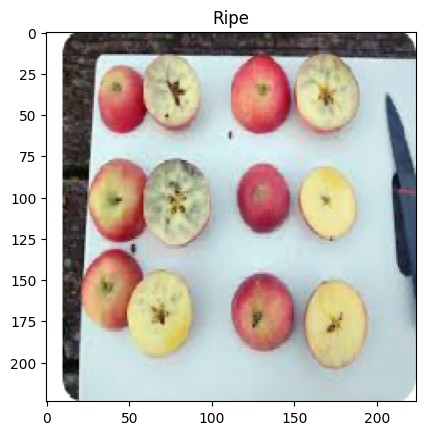

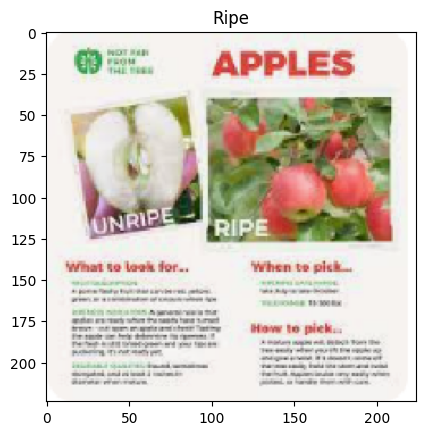

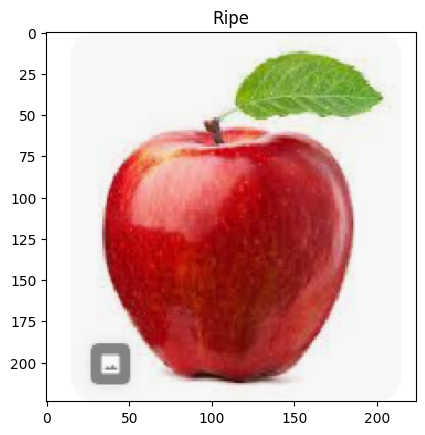

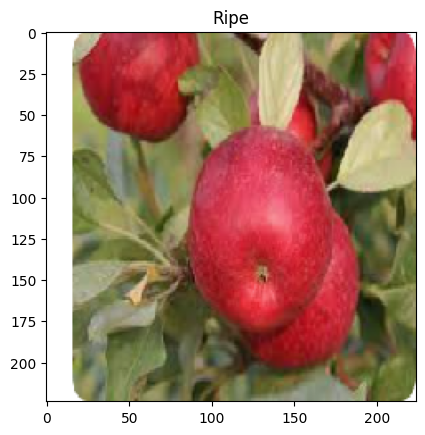

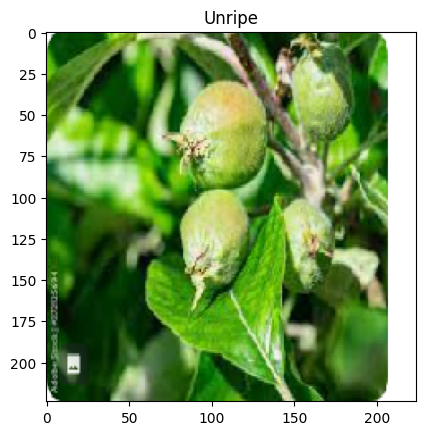

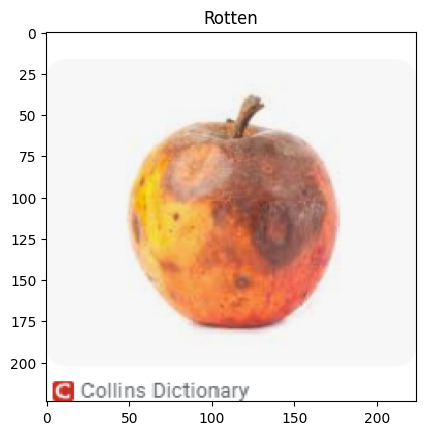

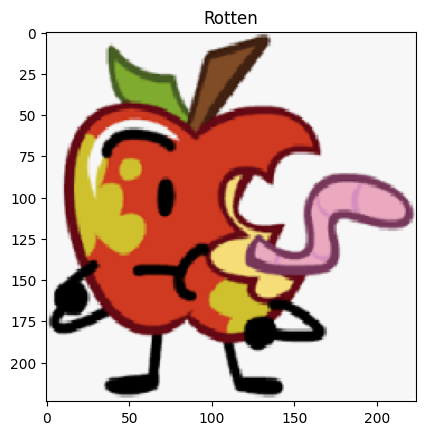

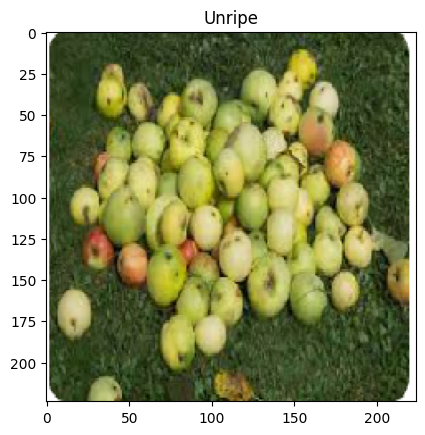

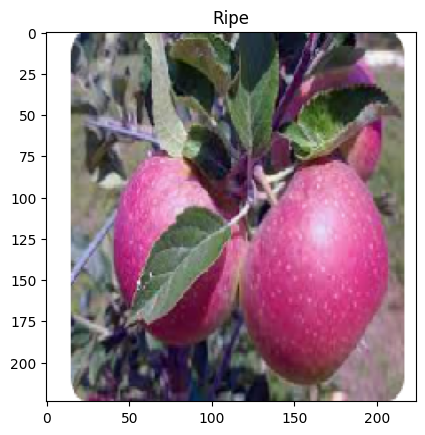

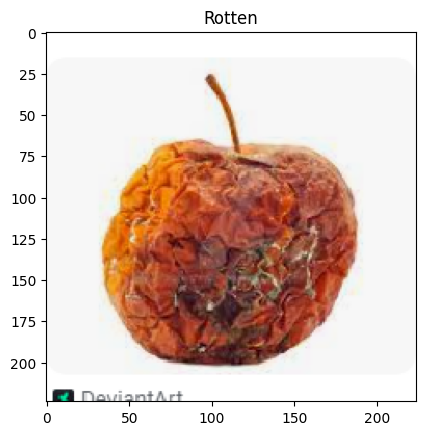

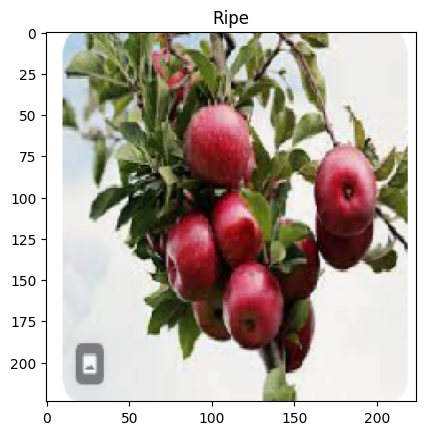

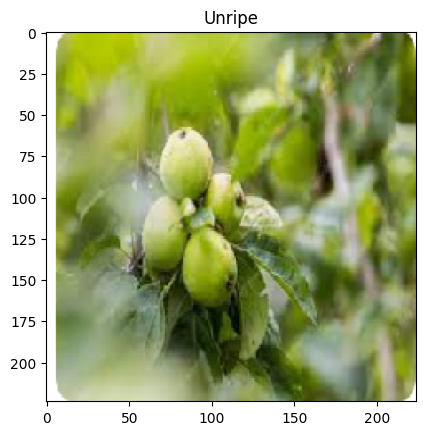

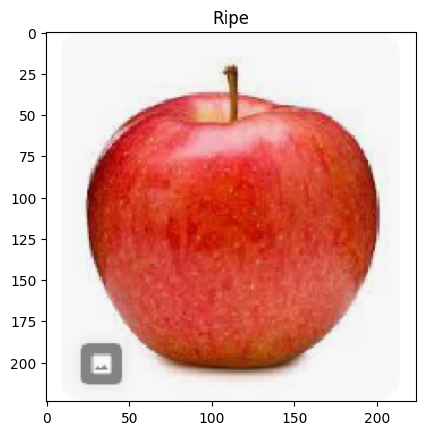

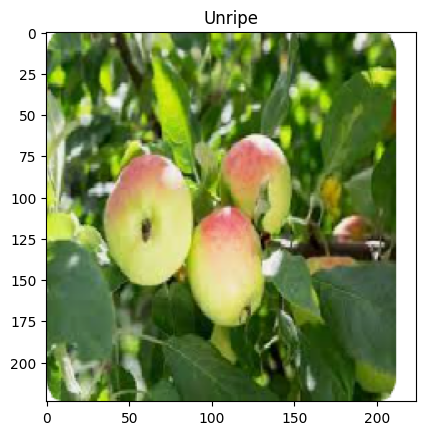

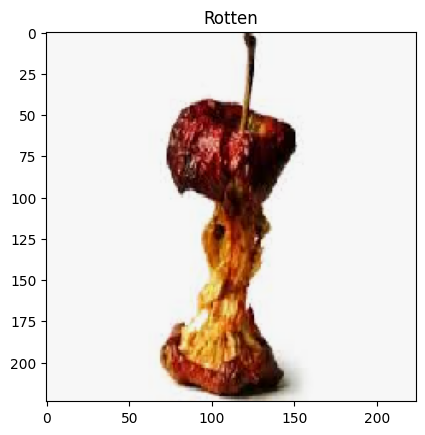

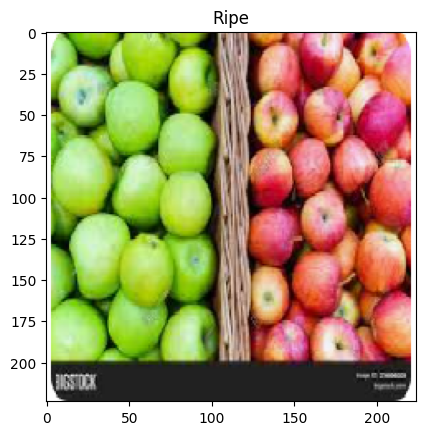

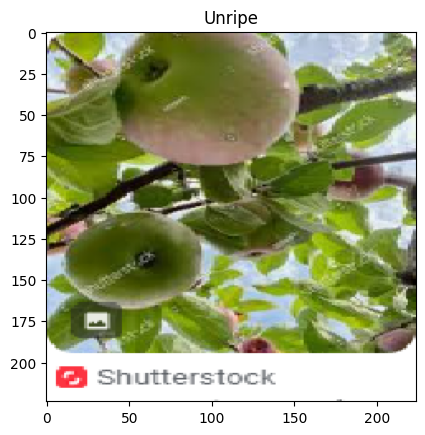

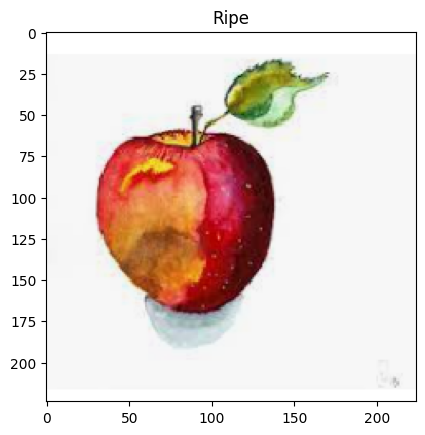

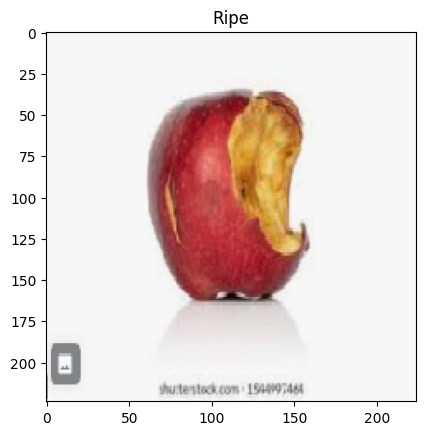

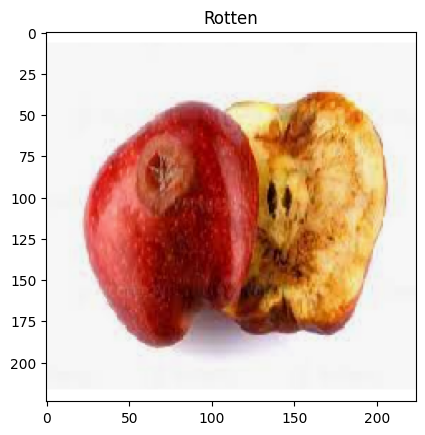

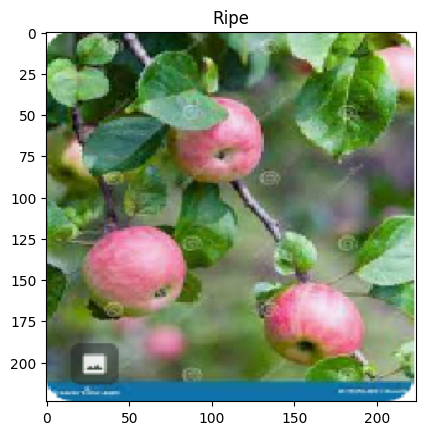

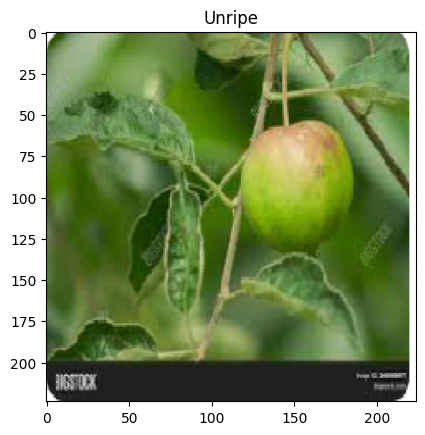

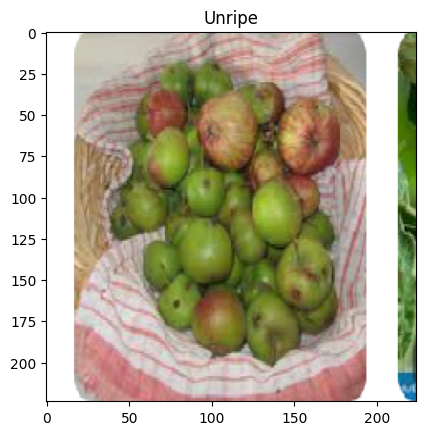

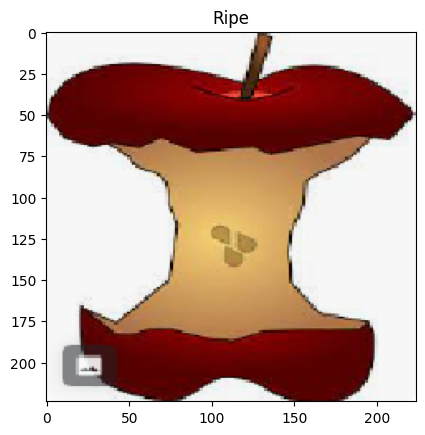

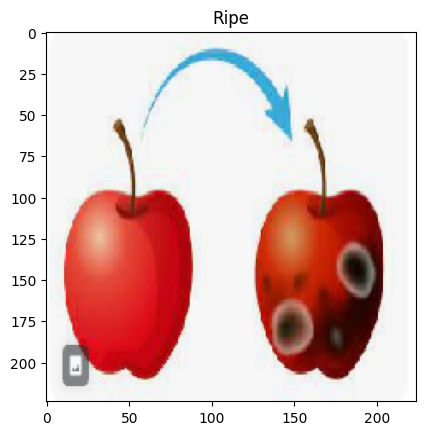

In [35]:
import matplotlib.pyplot as plt

for n in range((len(predicted_labels)-2)):
  plt.imshow(val_image_batch[n])
  plt.title(predicted_labels[n].title())
  plt.show()